In [3]:
import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

pd.set_option('max_info_columns', 999)
pd.options.display.max_rows = 200

%matplotlib inline

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.utils.np_utils import to_categorical

In [258]:
def clean_classes(x):
    if len(x) == 0:
        return "-1"
    elif "," in x:
        list_genre = x.split(",")
        new_genres = set(naming[converter[int(c)]] for c in list_genre)
        return ",".join(list(new_genres))
    else:
        return naming[converter[int(x)]]

# Preparation of data

## Loading Features

In [259]:
features = pd.read_csv("fma_metadata/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [260]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 518 columns):
(chroma_cens, kurtosis, 01)           106574 non-null float64
(chroma_cens, kurtosis, 02)           106574 non-null float64
(chroma_cens, kurtosis, 03)           106574 non-null float64
(chroma_cens, kurtosis, 04)           106574 non-null float64
(chroma_cens, kurtosis, 05)           106574 non-null float64
(chroma_cens, kurtosis, 06)           106574 non-null float64
(chroma_cens, kurtosis, 07)           106574 non-null float64
(chroma_cens, kurtosis, 08)           106574 non-null float64
(chroma_cens, kurtosis, 09)           106574 non-null float64
(chroma_cens, kurtosis, 10)           106574 non-null float64
(chroma_cens, kurtosis, 11)           106574 non-null float64
(chroma_cens, kurtosis, 12)           106574 non-null float64
(chroma_cens, max, 01)                106574 non-null float64
(chroma_cens, max, 02)                106574 non-null float64
(chroma_cens, max, 0

## Loading genres

In [261]:
genres = pd.read_csv("fma_metadata/genres.csv", index_col=0)
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


## Loading genres

In [262]:
tracks = pd.read_csv("fma_metadata/tracks.csv", 
                     header=[0, 1], 
                     skipinitialspace=True, 
                     index_col=0)
tracks = tracks[[("track", "genres_all"), ("track", "genres"), ("track", "genre_top")]]
tracks.columns = [col[1] for col in tracks.columns]
tracks.head()

,genres_all,genres,genre_top
track_id,,,
2,[21],[21],Hip-Hop
3,[21],[21],Hip-Hop
5,[21],[21],Hip-Hop
10,[10],[10],Pop
20,"[17, 10, 76, 103]","[76, 103]",NaN


In [263]:
tracks[tracks["genre_top"].isnull()]

,genres_all,genres,genre_top
track_id,,,
20,"[17, 10, 76, 103]","[76, 103]",NaN
26,"[17, 10, 76, 103]","[76, 103]",NaN
30,"[17, 10, 76, 103]","[76, 103]",NaN
46,"[17, 10, 76, 103]","[76, 103]",NaN
48,"[17, 10, 76, 103]","[76, 103]",NaN
...,...,...,...
155276,"[32, 38, 15]","[15, 32, 38]",NaN
155277,"[32, 38, 15]","[15, 32, 38]",NaN
155278,"[42, 107, 1235, 15]","[42, 107]",NaN


In [264]:
converter = genres[["top_level"]].to_dict()["top_level"]
naming = genres[["title"]].to_dict()["title"]

tracks["clean_class"] = tracks['genres_all'].str.replace("[^0-9,]", "").apply(clean_classes)
tracks = tracks[tracks["clean_class"] != "-1"]

In [265]:
tracks.head()

,genres_all,genres,genre_top,clean_class
track_id,,,,
2,[21],[21],Hip-Hop,Hip-Hop
3,[21],[21],Hip-Hop,Hip-Hop
5,[21],[21],Hip-Hop,Hip-Hop
10,[10],[10],Pop,Pop
20,"[17, 10, 76, 103]","[76, 103]",NaN,"Folk,Pop"


In [266]:
tracks["clean_class"].value_counts()

Rock                                14182
Experimental                        10608
Electronic                           9372
Experimental,Electronic              6851
Hip-Hop                              3552
                                    ...  
Instrumental,Rock,Spoken                1
Easy Listening,Pop,Jazz                 1
Easy Listening,Hip-Hop                  1
Instrumental,Old-Time / Historic        1
Blues,Experimental,Pop,Rock             1
Name: clean_class, Length: 495, dtype: int64

In [267]:
tracks_OHE = tracks["clean_class"].str.get_dummies(sep=',')

In [268]:
y = tracks_OHE.values

In [269]:
print("We now have {} observations and {} genres".format(*y.shape))
print("{:.02f}% of observation have more than 1 genre".format((y.sum(axis=1) > 1).mean()*100))
print("In average, a song has {:.02f} genres".format(y.sum(axis=1).mean()))
print("The balance of genre is :\n")
print(tracks_OHE.sum(axis=0))

We now have 104343 observations and 16 genres
52.47% of observation have more than 1 genre
In average, a song has 1.70 genres
The balance of genre is :

Blues                   1752
Classical               4106
Country                 1987
Easy Listening           730
Electronic             34413
Experimental           38154
Folk                   12706
Hip-Hop                 8389
Instrumental           14938
International           5271
Jazz                    4126
Old-Time / Historic      868
Pop                    13845
Rock                   32923
Soul-RnB                1499
Spoken                  1876
dtype: int64


In [270]:
tracks_OHE.to_csv("fma_metadata/classes.csv")

In [390]:
classes = pd.read_csv("fma_metadata/classes.csv")
classes.info()
classes = classes.drop(['Old-Time / Historic','Jazz','Classical','Country','Spoken','Blues','Soul-RnB','Easy Listening'], axis=1)
classes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104343 entries, 0 to 104342
Data columns (total 17 columns):
track_id               104343 non-null int64
Blues                  104343 non-null int64
Classical              104343 non-null int64
Country                104343 non-null int64
Easy Listening         104343 non-null int64
Electronic             104343 non-null int64
Experimental           104343 non-null int64
Folk                   104343 non-null int64
Hip-Hop                104343 non-null int64
Instrumental           104343 non-null int64
International          104343 non-null int64
Jazz                   104343 non-null int64
Old-Time / Historic    104343 non-null int64
Pop                    104343 non-null int64
Rock                   104343 non-null int64
Soul-RnB               104343 non-null int64
Spoken                 104343 non-null int64
dtypes: int64(17)
memory usage: 13.5 MB


,track_id,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
0,2,0,0,0,1,0,0,0,0
1,3,0,0,0,1,0,0,0,0
2,5,0,0,0,1,0,0,0,0
3,10,0,0,0,0,0,0,1,0
4,20,0,0,1,0,0,0,1,0


In [391]:
to_merge = classes.columns[1:]
id_ = classes.columns[0]

In [392]:
temp = pd.melt(classes, id_vars = id_, value_vars = to_merge)
temp = temp[temp.value == 1]
temp = temp.drop("value", axis=1)
temp = temp.set_index("track_id")

In [393]:
temp.head()

,variable
track_id,
236,Electronic
384,Electronic
385,Electronic
386,Electronic
387,Electronic


In [394]:
features = pd.read_csv("fma_metadata/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)

In [395]:
temp.columns = [("y", "y", "y")]  # required to join 2 dataset of same number of level

In [396]:
features = features.join(temp)

D:\anaconda\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [397]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        05        06   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.012226  0.012111   
3           1.366848  1.054094  0.108103  0.619185  ...  0.014212  0.017740   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.012691  0.014759   
10          1.770694  1.604566  0.521217  1.982386  ...  0.017952  0.013921   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.022492  0.021355   

feature           zcr                                                    \
statistics   kurtosis       max      mean    median       min      skew   
number             01        01        01        01        01        01   
track_id                                                                  
2            5.758890  0.459473  0.085629  0.071289  0.000000  2.089872   
3            2.824694  0.466309  0.084578  0.063965  0.000000  1.716724   
5            6.808415  0.375000  0.053114  0.041504  0.000000  2.193303   
10          21.434212  0.452148  0.077515  0.071777  0.000000  3.542325   
20          16.669037  0.469727  0.047225  0.040039  0.000977  3.189831   

feature                     y  
statistics       std        y  
number            01        y  
track_id                       
2           0.061448  Hip-Hop  
3           0.069330  Hip-Hop  
5           0.044861  Hip-Hop  
10          0.040800      Pop  
20          0.030993     Folk  

[5 rows x 519 columns]

In [398]:
features = features[~features[("y", "y", "y")].isnull()]
features = features[ features['chroma_cens']['kurtosis']['03'] < 150 ]
features = features[ features['chroma_cens']['kurtosis']['08'] < 150 ]
features = features[ features['chroma_cens']['kurtosis']['11'] < 150 ]

features = features[ features['chroma_cqt']['kurtosis']['03'] < 150 ]

features = features[ features['chroma_stft']['kurtosis']['01'] < 150 ]

features = features[ features['chroma_stft']['skew']['01'] > -25 ]

features = features[ features['mfcc']['kurtosis']['01'] < 100 ]
features = features[ features['mfcc']['kurtosis']['02'] < 100 ]

features = features[ features['rmse']['kurtosis']['01'] < 100 ]

features = features[ features['spectral_bandwidth']['kurtosis']['01'] < 400 ]

In [399]:
X = features.drop(("y", "y", "y"), axis=1).values
print(X)
y = features[("y", "y", "y")].values


[[ 7.18e+00  5.23e+00  2.49e-01 ...  0.00e+00  2.09e+00  6.14e-02]
 [ 1.89e+00  7.61e-01  3.45e-01 ...  0.00e+00  1.72e+00  6.93e-02]
 [ 5.28e-01 -7.77e-02 -2.80e-01 ...  0.00e+00  2.19e+00  4.49e-02]
 ...
 [-1.77e-01  1.87e-01 -5.07e-02 ...  4.88e-03  1.82e+00  2.01e-02]
 [ 4.90e-01  1.86e+00  8.54e-01 ...  4.39e-03  4.69e+00  1.37e-01]
 [ 4.90e-01  1.86e+00  8.54e-01 ...  4.39e-03  4.69e+00  1.37e-01]]


In [400]:
np.save("new_X.npy", X)
np.save("new_y.npy", y)

In [5]:
X = np.load("new_X.npy",allow_pickle=True)
y = np.load("new_y.npy",allow_pickle=True)

In [6]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)
print(X)

[[ 7.18065262e+00  5.23030901e+00  2.49320805e-01 ...  0.00000000e+00
   2.08987212e+00  6.14481084e-02]
 [ 1.88896334e+00  7.60539293e-01  3.45296562e-01 ...  0.00000000e+00
   1.71672380e+00  6.93301633e-02]
 [ 5.27562976e-01 -7.76543170e-02 -2.79610306e-01 ...  0.00000000e+00
   2.19330311e+00  4.48606014e-02]
 ...
 [-1.05701673e+00 -4.37589318e-01 -7.83426702e-01 ...  2.44140625e-03
   4.12366915e+00  1.62311681e-02]
 [ 1.31789839e+00  1.36346507e+00  1.58729208e+00 ...  1.95312500e-03
   3.04287761e-01  2.49183290e-02]
 [ 1.40208733e+00 -6.60064518e-01 -3.82776022e-01 ...  1.66015625e-02
   2.48253298e+00  3.28679755e-02]]


Now our dataset should be balanced. Let'(s apply a Label Bisarizer and count each class

In [7]:
enc = LabelBinarizer()
y = enc.fit_transform(y.reshape(-1, 1))

In [8]:
y.sum(axis=0)

array([37904, 37904, 37904, 37904, 37904, 37904, 37904, 37904])

In [9]:
y.shape
np.save("labels",y)

We properly have the same number of classes and the same number of observations. We can now apply the same pre-processing as the previous notebbok but with 610464 observations, there is no need to apply a PCA to reduce dimensions

# Data preparation

In [10]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
print(X.shape)

(303232, 518)


In [11]:
pca = PCA(518)
new_X = pca.fit_transform(X)
new_X.shape
np.save("pcamatrix",new_X)


In [12]:
print(X)

[[ 1.72852941e-01  2.08540191e+00  3.33079083e-02 ... -4.74185792e-01
  -4.11013582e-01  7.81888094e-01]
 [ 3.78101379e-02  2.81014382e-01  7.71943764e-02 ... -4.74185792e-01
  -5.38071083e-01  1.08026153e+00]
 [ 3.06748532e-03 -5.73534066e-02 -2.08554403e-01 ... -4.74185792e-01
  -3.75795194e-01  1.53971693e-01]
 ...
 [-3.73706573e-02 -2.02654455e-01 -4.38932604e-01 ...  4.79566115e-02
   2.81497015e-01 -9.29789162e-01]
 [ 2.32366799e-02  5.24407626e-01  6.45116926e-01 ... -5.64718691e-02
  -1.01900744e+00 -6.00938611e-01]
 [ 2.53851639e-02 -2.92464781e-01 -2.55728596e-01 ...  3.07638255e+00
  -2.77312037e-01 -3.00006502e-01]]


An important thing to do also is to shuffle the dataset as it was sorted by class du to the melt and the RandomOverSampler. After that, the training will be done using a random split on the training set. But we will keep a validation set out.

In [13]:
X = np.load("pcamatrix.npy",allow_pickle=True)
y = np.load("labels.npy",allow_pickle=True)

In [14]:

X, y = shuffle(X, y, random_state=0)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
del X
del y

# Model

In [17]:
K.clear_session()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               132864    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 174,536
Trainable params: 174,536
Non-trainable params: 0
________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Nadam', 
              metrics=["categorical_crossentropy", "accuracy"])

In [20]:
history = model.fit(X_train, y_train, 
                      epochs=200, 
                      batch_size=1000, 
                      verbose=1, 
                      validation_split=0.2)

Train on 181939 samples, validate on 45485 samples
Epoch 1/200
181939/181939 [==============================] - 5s 27us/step - loss: 1.7386 - categorical_crossentropy: 1.7386 - accuracy: 0.3521 - val_loss: 1.5399 - val_categorical_crossentropy: 1.5399 - val_accuracy: 0.4283
Epoch 2/200
181939/181939 [==============================] - 4s 22us/step - loss: 1.5452 - categorical_crossentropy: 1.5452 - accuracy: 0.4272 - val_loss: 1.4593 - val_categorical_crossentropy: 1.4593 - val_accuracy: 0.4546
Epoch 3/200
181939/181939 [==============================] - 7s 37us/step - loss: 1.4530 - categorical_crossentropy: 1.4530 - accuracy: 0.4589 - val_loss: 1.4010 - val_categorical_crossentropy: 1.4010 - val_accuracy: 0.4755
Epoch 4/200
181939/181939 [==============================] - 7s 39us/step - loss: 1.3808 - categorical_crossentropy: 1.3808 - accuracy: 0.4835 - val_loss: 1.3523 - val_categorical_crossentropy: 1.3523 - val_accuracy: 0.4917
Epoch 5/200
181939/181939 [==========================

Epoch 37/200
181939/181939 [==============================] - 6s 34us/step - loss: 0.9207 - categorical_crossentropy: 0.9207 - accuracy: 0.6386 - val_loss: 1.2426 - val_categorical_crossentropy: 1.2426 - val_accuracy: 0.5793
Epoch 38/200
181939/181939 [==============================] - 6s 35us/step - loss: 0.9161 - categorical_crossentropy: 0.9161 - accuracy: 0.6396 - val_loss: 1.2575 - val_categorical_crossentropy: 1.2575 - val_accuracy: 0.5781
Epoch 39/200
181939/181939 [==============================] - 6s 33us/step - loss: 0.9141 - categorical_crossentropy: 0.9141 - accuracy: 0.6412 - val_loss: 1.2532 - val_categorical_crossentropy: 1.2532 - val_accuracy: 0.5787
Epoch 40/200
181939/181939 [==============================] - 6s 35us/step - loss: 0.9103 - categorical_crossentropy: 0.9103 - accuracy: 0.6414 - val_loss: 1.2589 - val_categorical_crossentropy: 1.2589 - val_accuracy: 0.5805
Epoch 41/200
181939/181939 [==============================] - 6s 32us/step - loss: 0.9042 - categori

181939/181939 [==============================] - 6s 31us/step - loss: 0.8289 - categorical_crossentropy: 0.8289 - accuracy: 0.6677 - val_loss: 1.3850 - val_categorical_crossentropy: 1.3850 - val_accuracy: 0.5870
Epoch 74/200
181939/181939 [==============================] - 5s 29us/step - loss: 0.8276 - categorical_crossentropy: 0.8276 - accuracy: 0.6672 - val_loss: 1.3859 - val_categorical_crossentropy: 1.3859 - val_accuracy: 0.5867
Epoch 75/200
181939/181939 [==============================] - 5s 28us/step - loss: 0.8270 - categorical_crossentropy: 0.8270 - accuracy: 0.6684 - val_loss: 1.4029 - val_categorical_crossentropy: 1.4029 - val_accuracy: 0.5892
Epoch 76/200
181939/181939 [==============================] - 5s 30us/step - loss: 0.8238 - categorical_crossentropy: 0.8238 - accuracy: 0.6687 - val_loss: 1.3967 - val_categorical_crossentropy: 1.3967 - val_accuracy: 0.5873
Epoch 77/200
181939/181939 [==============================] - 5s 29us/step - loss: 0.8224 - categorical_crossentr

181939/181939 [==============================] - 5s 28us/step - loss: 0.7839 - categorical_crossentropy: 0.7839 - accuracy: 0.6794 - val_loss: 1.5549 - val_categorical_crossentropy: 1.5549 - val_accuracy: 0.5916
Epoch 110/200
181939/181939 [==============================] - 5s 28us/step - loss: 0.7837 - categorical_crossentropy: 0.7837 - accuracy: 0.6790 - val_loss: 1.5306 - val_categorical_crossentropy: 1.5306 - val_accuracy: 0.5917
Epoch 111/200
181939/181939 [==============================] - 5s 28us/step - loss: 0.7800 - categorical_crossentropy: 0.7800 - accuracy: 0.6803 - val_loss: 1.5491 - val_categorical_crossentropy: 1.5491 - val_accuracy: 0.5887
Epoch 112/200
181939/181939 [==============================] - 5s 29us/step - loss: 0.7794 - categorical_crossentropy: 0.7794 - accuracy: 0.6810 - val_loss: 1.5655 - val_categorical_crossentropy: 1.5655 - val_accuracy: 0.5911
Epoch 113/200
181939/181939 [==============================] - 5s 28us/step - loss: 0.7799 - categorical_cross

181939/181939 [==============================] - 8s 41us/step - loss: 0.7500 - categorical_crossentropy: 0.7500 - accuracy: 0.6884 - val_loss: 1.6639 - val_categorical_crossentropy: 1.6639 - val_accuracy: 0.5921
Epoch 146/200
181939/181939 [==============================] - 7s 38us/step - loss: 0.7523 - categorical_crossentropy: 0.7523 - accuracy: 0.6881 - val_loss: 1.6899 - val_categorical_crossentropy: 1.6899 - val_accuracy: 0.5904
Epoch 147/200
181939/181939 [==============================] - 7s 38us/step - loss: 0.7528 - categorical_crossentropy: 0.7528 - accuracy: 0.6875 - val_loss: 1.6712 - val_categorical_crossentropy: 1.6712 - val_accuracy: 0.5926
Epoch 148/200
181939/181939 [==============================] - 7s 36us/step - loss: 0.7506 - categorical_crossentropy: 0.7506 - accuracy: 0.6882 - val_loss: 1.6875 - val_categorical_crossentropy: 1.6875 - val_accuracy: 0.5913
Epoch 149/200
181939/181939 [==============================] - 7s 38us/step - loss: 0.7488 - categorical_cross

181939/181939 [==============================] - 6s 35us/step - loss: 0.7315 - categorical_crossentropy: 0.7315 - accuracy: 0.6927 - val_loss: 1.8096 - val_categorical_crossentropy: 1.8096 - val_accuracy: 0.5934
Epoch 181/200
181939/181939 [==============================] - 7s 40us/step - loss: 0.7290 - categorical_crossentropy: 0.7290 - accuracy: 0.6939 - val_loss: 1.8158 - val_categorical_crossentropy: 1.8158 - val_accuracy: 0.5916
Epoch 182/200
181939/181939 [==============================] - 8s 42us/step - loss: 0.7397 - categorical_crossentropy: 0.7397 - accuracy: 0.6911 - val_loss: 1.7700 - val_categorical_crossentropy: 1.7700 - val_accuracy: 0.5892
Epoch 183/200
181939/181939 [==============================] - 7s 40us/step - loss: 0.7307 - categorical_crossentropy: 0.7307 - accuracy: 0.6925 - val_loss: 1.7989 - val_categorical_crossentropy: 1.7989 - val_accuracy: 0.5892
Epoch 184/200
181939/181939 [==============================] - 7s 36us/step - loss: 0.7243 - categorical_cross

In [21]:
model.save('final_model.h5') 

# Result

Stability is reach quite fast. we can now evaluate it on the validation set.

In [153]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('win_model1.h5')
print('model loaded ...')

model loaded ...


In [22]:
y_pred = model.predict(X_val, batch_size=500)
"""Xtesst =np.load("6.npy",allow_pickle=True)

Xtest1 = MinMaxScaler().fit_transform(Xtesst)
y_X = model.predict(Xtest1)"""


'Xtesst =np.load("6.npy",allow_pickle=True)\n\nXtest1 = MinMaxScaler().fit_transform(Xtesst)\ny_X = model.predict(Xtest1)'

In [385]:
# just to clear memory

K.clear_session()
del X_train
del y_train

In [24]:
y_pred[50, :]
#print(y_X[0])
"""dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }
key_list = list(dict_genres.keys()) 
val_list = list(dict_genres.values()) 
j = 0
a = max(y_X[0])
print(a)
for i in range(len(y_X[0])-1):
    if y_X[0][i] == a:
        j = i 
df = pd.DataFrame({'genre':['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 
               'Instrumental','International', 'Pop' , 'Rock'], '%':y_X[0]*100})
ax = df.plot.bar(x='genre', y='%', rot=0)
    




[0.09 0.06 0.12 0.13 0.06 0.24 0.18 0.11]"""



"dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, \n               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }\nkey_list = list(dict_genres.keys()) \nval_list = list(dict_genres.values()) \nj = 0\na = max(y_X[0])\nprint(a)\nfor i in range(len(y_X[0])-1):\n    if y_X[0][i] == a:\n        j = i \ndf = pd.DataFrame({'genre':['Electronic', 'Experimental', 'Folk', 'Hip-Hop', \n               'Instrumental','International', 'Pop' , 'Rock'], '%':y_X[0]*100})\nax = df.plot.bar(x='genre', y='%', rot=0)\n    \n\n\n\n\n[0.09 0.06 0.12 0.13 0.06 0.24 0.18 0.11]"

First if we look at prediction, we can see that there is no clear prediction, that starts bad... Let's look at the Confusion matrix

In [25]:
y_ohe = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

In [26]:
y_pred_classe = enc.inverse_transform(y_ohe)
y_val_classe = enc.inverse_transform(y_val)

Normalized confusion matrix


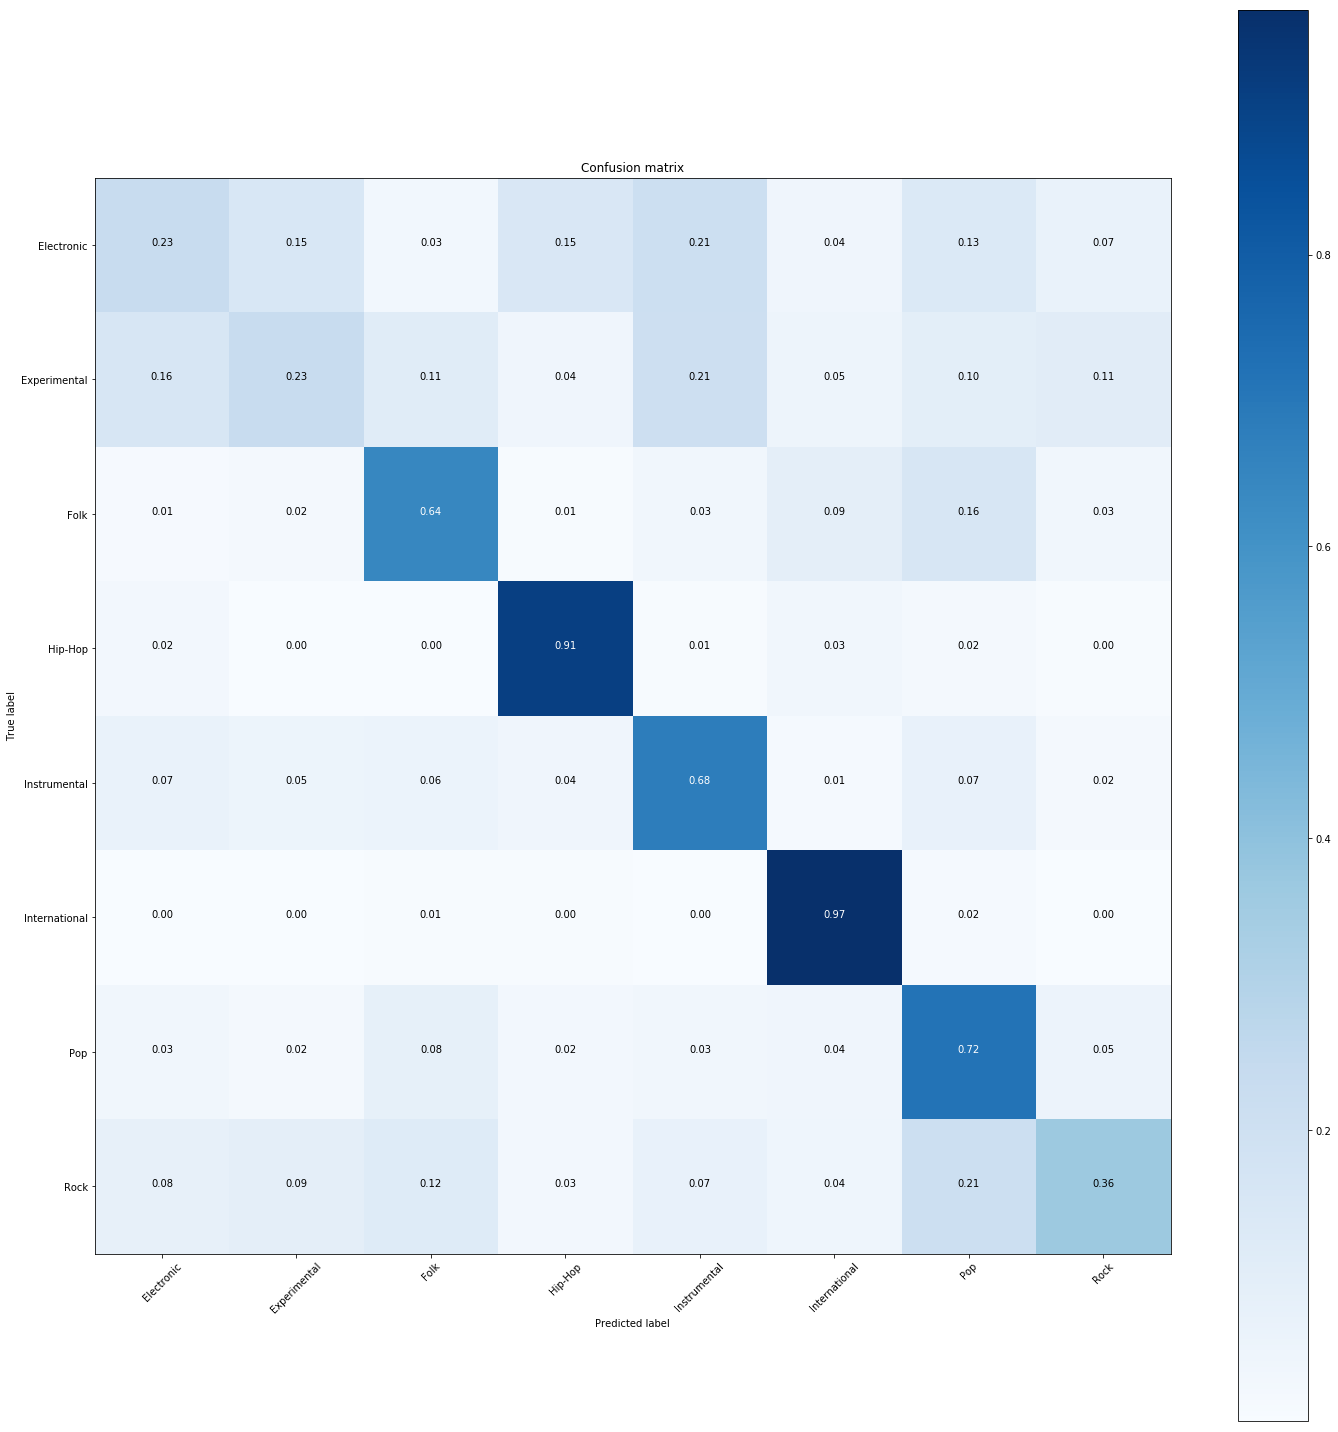

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_val_classe, y_pred_classe)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=enc.classes_)
plt.show()

Strange for a prediction of 94%. Let's look at the accuracy on validation set manually

In [28]:
accuracy_score(y_val, y_ohe)

0.5938951034191642

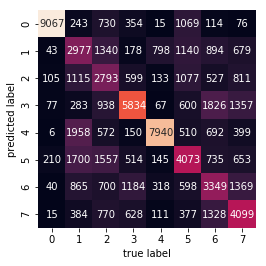

In [502]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_val_classe, y_pred_classe)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [451]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('win_mod8.h5')

print('model loaded ...')
loaded_model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", "accuracy"])

model loaded ...


In [29]:

Xtesst1 =np.load("00.npy",allow_pickle=True)





print(Xtesst1)








[[-1.73e-01  1.22e-01 -2.94e-01 -5.72e-01 -5.10e-01 -5.22e-01 -2.33e-01
  -5.18e-01  3.53e-01  6.03e-01 -6.67e-02  9.01e-01  5.98e-01  6.58e-01
   6.65e-01  4.79e-01  5.72e-01  5.76e-01  6.75e-01  5.02e-01  6.15e-01
   6.59e-01  5.26e-01  6.61e-01  2.96e-01  3.40e-01  2.99e-01  2.44e-01
   2.76e-01  2.89e-01  2.59e-01  2.16e-01  2.37e-01  2.50e-01  2.11e-01
   1.95e-01  2.86e-01  3.51e-01  2.96e-01  2.35e-01  2.57e-01  2.79e-01
   2.33e-01  1.99e-01  2.25e-01  2.24e-01  1.99e-01  1.71e-01  1.57e-02
   6.54e-03  1.07e-02  6.45e-03  1.35e-02  8.34e-03  2.06e-03  1.12e-03
   2.44e-02  2.34e-02  1.71e-03  1.15e-03 -2.94e-02 -2.13e-01  1.17e-01
   1.25e-01  2.77e-01 -1.35e-01  6.43e-01  4.68e-01  8.30e-01  9.56e-01
   5.93e-01  9.71e-01  1.02e-01  1.22e-01  1.28e-01  1.04e-01  1.14e-01
   1.13e-01  1.44e-01  1.16e-01  1.21e-01  1.34e-01  1.08e-01  1.27e-01
  -8.86e-01 -1.13e+00 -1.19e+00 -9.34e-01 -1.25e+00 -7.77e-01 -1.15e+00
  -5.97e-01 -6.28e-01 -9.08e-01 -4.40e-01 -6.77e-01  1.00e+00  1

In [496]:
y_X = loaded_model.predict(Xtesst1)




ValueError: Error when checking input: expected dense_1_input to have shape (518,) but got array with shape (1,)

0.66082054
Pop


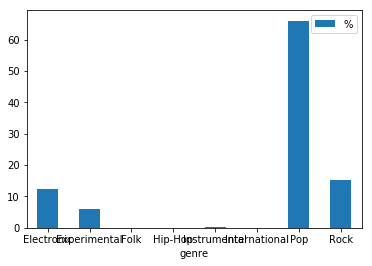

In [471]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }
key_list = list(dict_genres.keys()) 
val_list = list(dict_genres.values()) 
j = 0
a = max(y_X[0])
print(a)
for i in range(len(y_X[0])-1):
    if y_X[0][i] == a:
        j = i 
        
df = pd.DataFrame({'genre':['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 
               'Instrumental','International', 'Pop' , 'Rock'], '%':y_X[0]*100})
print(key_list[j])
ax = df.plot.bar(x='genre', y='%', rot=0)
ax.get_figure().savefig('4.png')




# Analysis

Suprise... only 30%. Why the result is so low? My guess is due to the oversampling method. I was expecting the model to minimize the loss and prediction for example 50%/50% as 1 observation can be either one or the other. but with the oversampling, we introduce a lot of noise as a small variation of a Pop Rock song can be Rock only for example. This is clearly not a good solution.

Before to Finish, let's just try the model on unbalanced dataset. maybe the result will be better

In [217]:
features = pd.read_csv("fma_metadata/features.csv", 
                       header=[0, 1, 2], skipinitialspace=True, index_col=0)
classes = pd.read_csv("fma_metadata/classes.csv", index_col=0)

In [218]:
features = features[features.index.isin(classes.index)]

In [219]:
X = features.values
y = classes.values

In [220]:
X = MinMaxScaler().fit_transform(X)
pca = PCA(n_components=0.99)
new_X = pca.fit_transform(X)

In [221]:
X, y = shuffle(X, y, random_state=0)

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [223]:
K.clear_session()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               132864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
Total params: 150,352
Trainable params: 150,352
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", "accuracy"])

In [225]:
history = model.fit(X_train, y_train, 
                      epochs=25, 
                      batch_size=1000, 
                      verbose=1, 
                      validation_split=0.2)

Train on 70952 samples, validate on 17739 samples
Epoch 1/25
70952/70952 [==============================] - 2s 28us/step - loss: 0.2996 - binary_crossentropy: 0.2996 - accuracy: 0.8933 - val_loss: 0.2738 - val_binary_crossentropy: 0.2738 - val_accuracy: 0.8931
Epoch 2/25
70952/70952 [==============================] - 1s 21us/step - loss: 0.2780 - binary_crossentropy: 0.2780 - accuracy: 0.8944 - val_loss: 0.2710 - val_binary_crossentropy: 0.2710 - val_accuracy: 0.8939
Epoch 3/25
70952/70952 [==============================] - 1s 20us/step - loss: 0.2709 - binary_crossentropy: 0.2709 - accuracy: 0.8952 - val_loss: 0.2667 - val_binary_crossentropy: 0.2667 - val_accuracy: 0.8979
Epoch 4/25
70952/70952 [==============================] - 1s 20us/step - loss: 0.2688 - binary_crossentropy: 0.2688 - accuracy: 0.8961 - val_loss: 0.2635 - val_binary_crossentropy: 0.2635 - val_accuracy: 0.8931
Epoch 5/25
70952/70952 [==============================] - 1s 20us/step - loss: 0.2634 - binary_crossentrop

In [226]:
y_pred = model.predict(X_val, batch_size=500)

In [227]:
K.clear_session()
del X_train
del y_train

In [235]:
dict_genres = {}

y_pred[10, :][0]


0.008155759

In [229]:
y_ohe = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
print(y_ohe)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [230]:
accuracy_score(y_val, y_ohe)

0.27446971633018147

Only 28% ... still low but we should keep in mind that we may predict multiclass so we should consider as true all class for example above 0.3

In [231]:
y_ohe2 = (y_pred>0.32).astype(int)
accuracy_score(y_val, y_ohe2)

0.2259775108612318

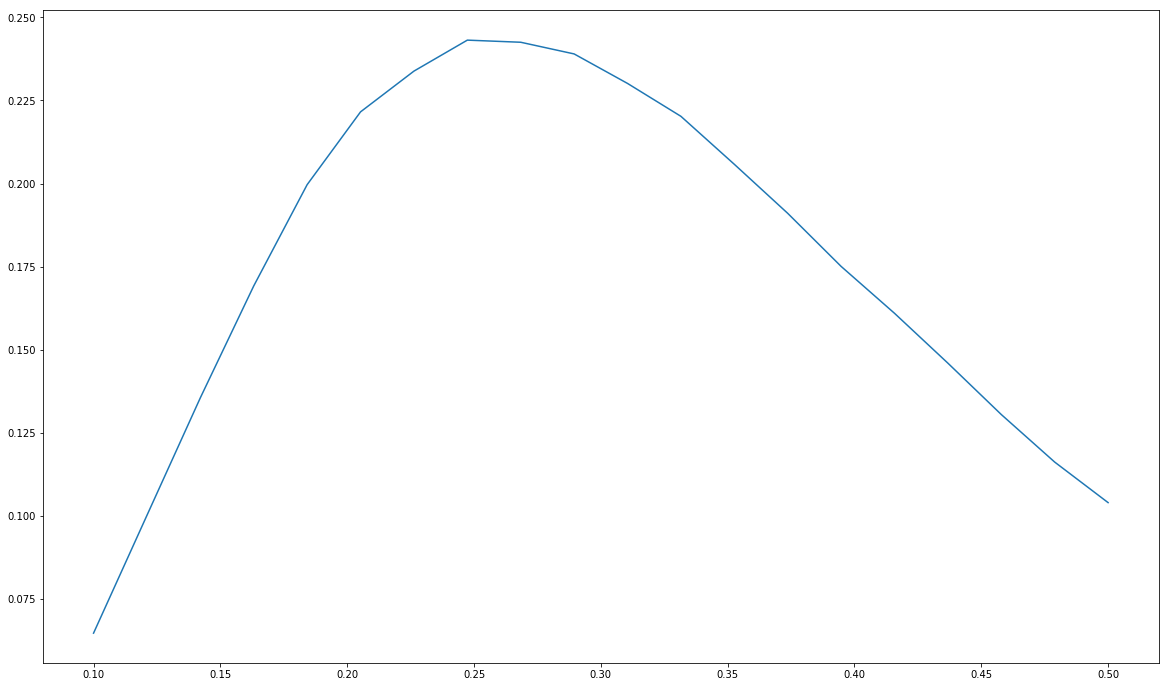

In [232]:
x_axis = np.linspace(0.1, 0.5, 20)
y_axis = []
for x in x_axis:
    y_ohe2 = (y_pred>x).astype(int)
    y = accuracy_score(y_val, y_ohe2)
    y_axis.append(y)

plt.figure(figsize=(20,12))
plt.plot(x_axis, y_axis)
plt.show()

We can see that the best accuracy is reached at 0.23 threshold but it's only 26%... We cannot do the confusion matrix as we are multilabel but here we can see that the result is not very good too. The good point is that we are sure there is no overfitting due to Oversampling or duplicate records. Nevertheless the result is not good too. One improvement we can do is to look at WaveNet model to extract features in a latent space and maybe the result will be the best as it uses the state of arts in term of model

Normalized confusion matrix


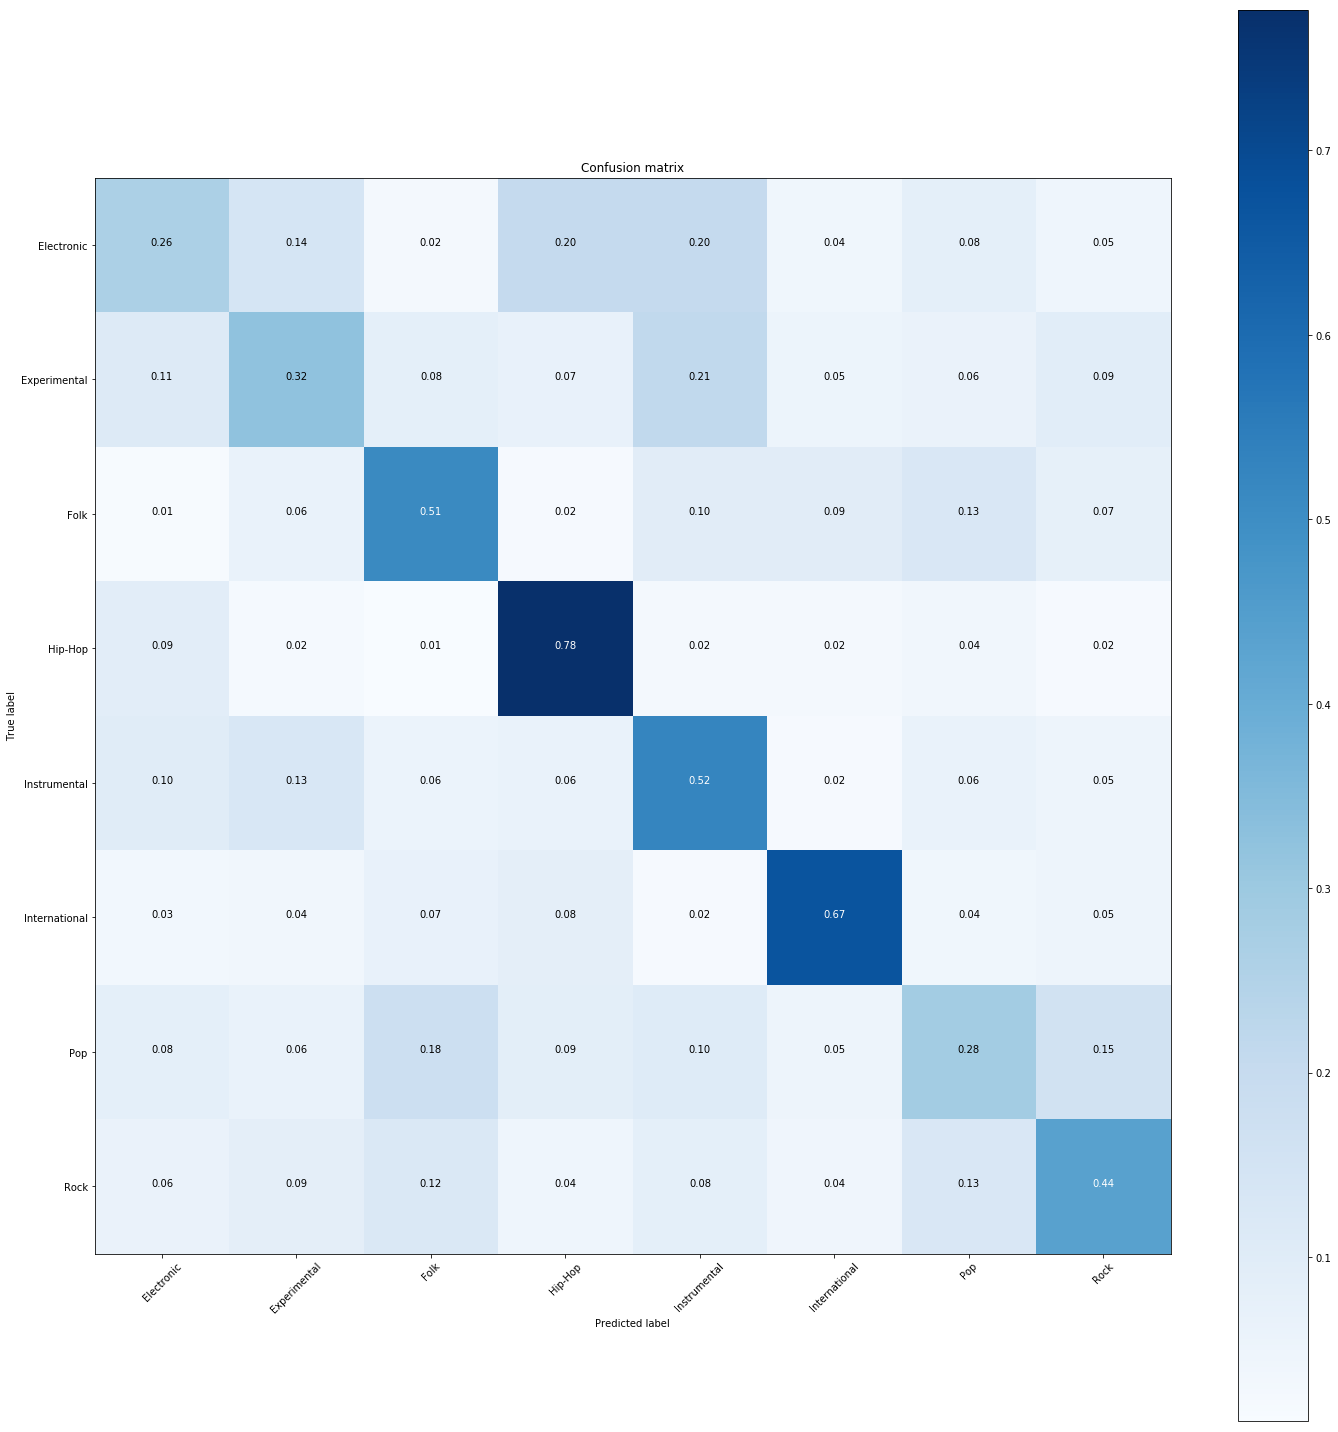

In [234]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_val_classe, y_pred_classe)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=enc.classes_)
plt.show()